**Aufgabe 1**
*Berechnen Sie die erste und zweite Variation des Funktionals $E^{IE}$ (3).
Zeigen Sie, dass die erste Variation mit dem impliziten Euler-Verfahren übereinstimmt.*

*1. Variation (Gateuax Ableitung)*

Das Funktional ist gegeben durch:
$E^{IE}(u) = [ \int_{\Omega\} \epsilon\/2|| \,dx ]$

In [19]:
from netgen.meshing import *
from ngsolve import *
from ngsolve.webgui import Draw
from netgen.geom2d import SplineGeometry
import matplotlib.pyplot as plt
import numpy as np

In [20]:
mesh = Mesh(unit_square.GenerateMesh(maxh=0.1))
Draw(mesh)

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

BaseWebGuiScene

In [21]:
def unitIntervallMesh(N=5):
    m = NGMesh(dim=1)
 
    # Punkte für die Zerlegung auf dem Intervall [0,1]
    pnums = []
    for i in range(0, N+1):
        pnums.append (m.Add (MeshPoint (Pnt(i/N, 0, 0))))
 
    # Jedes 1D-Element (Teilintervall) kann einem Material zugeordnet
    # werden. In unserem Fall gibt es nur ein Material.
    idx = m.AddRegion("material", dim=1)
    for i in range(0,N):
        m.Add (Element1D ([pnums[i],pnums[i+1]], index=idx))
 
    # Linkes und Rechtes Ende sind Randwertpunkte (0D-Elemente)
    idx_left = m.AddRegion("left", dim=0)
    idx_right = m.AddRegion("right", dim=0)
 
    m.Add (Element0D (pnums[0], index=idx_left))
    m.Add (Element0D (pnums[N], index=idx_right))
 
    # Damit haben wir das Mesh definiert
    mesh = Mesh(m)
    return mesh

In [22]:
# Geg:
eps = 1e-6
# dt = 2.5e-1
dt = 1
t0 = 0
tend = 2
t = t0

In [23]:
# Annahme n = 5 für das Mesh
# Mesh von Herrn Stingelin verwendet
# FEM Raum => Annahme Order = 2
V = H1(mesh, order=2)  

# Trial Funktion
u = V.TrialFunction()
# Test Funktion 
v = V.TestFunction()

gfuold = GridFunction(V)
a = BilinearForm (V, symmetric=False)
a += Variation((eps/2*grad(u)*grad(u) 
               +(u**2*(1-u*u)**2)
               + 0.5/dt*(u-gfuold)**2)*dx)


In [24]:
def plot(gfu):
    xis = np.linspace(0,1,400)
    uis = np.array([gfu(mesh(xi)) for xi in xis])
    plt.plot(xis,uis,label='FEM Lösung')

In [25]:
'''
f = LinearForm(V)
f += CoefficientFunction(x*exp(-x**2))*v*dx

a.Assemble()
f.Assemble()

while t == tend:
    # Solve the variational problem
    a.Assemble()
    # nur wenn rechte Seite NICHT "festgemacht" ist!
    # f = LinearForm(V)
    f.Assemble()
    inv = a.mat.Inverse(V.FreeDofs())

    gfu = GridFunction(V)
    gfu.vec.data = a.mat.Inverse(freedofs=V.FreeDofs())*f.vec
    # print(f"this is vec.data: {gfu.vec.data}")

    plot(gfu)

    # Update the solution at the previous time step
    gfuold.vec.data = gfu.vec

    # Increment the time and continue the loop
    t += dt


plt.show()
'''

'\nf = LinearForm(V)\nf += CoefficientFunction(x*exp(-x**2))*v*dx\n\na.Assemble()\nf.Assemble()\n\nwhile t == tend:\n    # Solve the variational problem\n    a.Assemble()\n    # nur wenn rechte Seite NICHT "festgemacht" ist!\n    # f = LinearForm(V)\n    f.Assemble()\n    inv = a.mat.Inverse(V.FreeDofs())\n\n    gfu = GridFunction(V)\n    gfu.vec.data = a.mat.Inverse(freedofs=V.FreeDofs())*f.vec\n    # print(f"this is vec.data: {gfu.vec.data}")\n\n    plot(gfu)\n\n    # Update the solution at the previous time step\n    gfuold.vec.data = gfu.vec\n\n    # Increment the time and continue the loop\n    t += dt\n\n\nplt.show()\n'

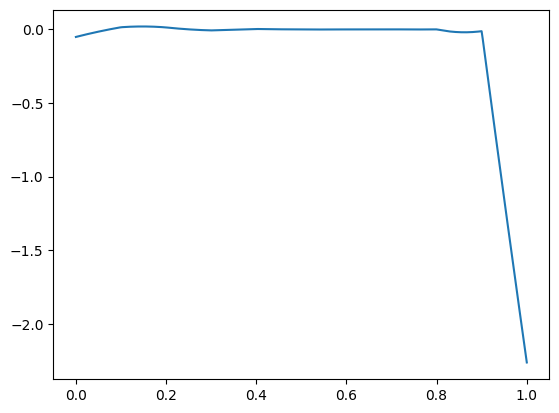

In [26]:
f = LinearForm(V)
f += CoefficientFunction(x*exp(-x**2))*v*dx

a.Assemble()
f.Assemble()


# Solve the variational problem
a.Assemble()
# nur wenn rechte Seite NICHT "festgemacht" ist!
# f = LinearForm(V)
f.Assemble()
inv = a.mat.Inverse(V.FreeDofs())

gfu = GridFunction(V)
gfu.vec.data = a.mat.Inverse(freedofs=V.FreeDofs())*f.vec
# print(f"this is vec.data: {gfu.vec.data}")

xis = np.linspace(0,1,400)
uis = np.array([gfu(mesh(xi)) for xi in xis])
plt.plot(xis,uis,label='FEM Lösung')
plt.show()

# Update the solution at the previous time step
gfuold.vec.data = gfu.vec

# Increment the time and continue the loop
t += dt

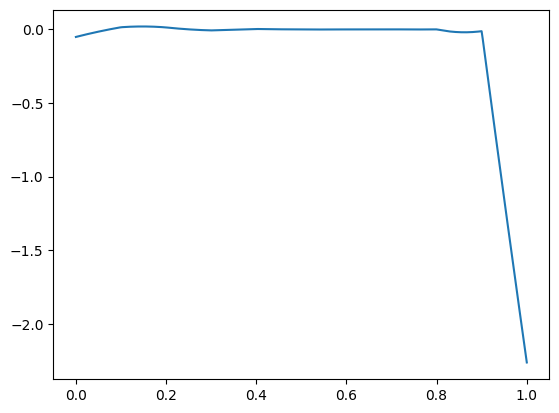

In [27]:
# Solve the variational problem
a.Assemble()
# nur wenn rechte Seite NICHT "festgemacht" ist!
# f = LinearForm(V)
f.Assemble()
inv = a.mat.Inverse(V.FreeDofs())

gfu = GridFunction(V)
gfu.vec.data = a.mat.Inverse(freedofs=V.FreeDofs())*f.vec
# print(f"this is vec.data: {gfu.vec.data}")

xis = np.linspace(0,1,400)
uis = np.array([gfu(mesh(xi)) for xi in xis])
plt.plot(xis,uis,label='FEM Lösung')
plt.show()

# Update the solution at the previous time step
gfuold.vec.data = gfu.vec

# Increment the time and continue the loop
t += dt